# SpatialDM tutorial with melanoma data

You may also run it on Google Colab with this link: [melanoma.ipynb](https://colab.research.google.com/github/StatBiomed/SpatialDM/blob/main/tutorial/melanoma.ipynb)

For the scripts below, please only install the package if you need (required on colab) but on your local environment, you only need to install for the first time.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata as ann

import spatialdm as sdm
from spatialdm.datasets import dataset
import spatialdm.plottings as pl

import matplotlib.pyplot as plt
print("SpatailDM version: %s" %sdm.__version__)

SpatailDM version: 0.2.0


The melanoma dataset from [Thrane, et al. 2018 Caner Cell](https://aacrjournals.org/cancerres/article/78/20/5970/631815) was publicly available.
We obtained raw counts, pre-processed log counts, and spatial coordinates from Matt Stone ([Git repository](https://github.com/msto/spatial-datasets)). For easier reuse, we included them in an anndata object which can be loaded directly in SpatialDM Python package.

We can see the histology image below from the orignal supplementary figure (the first sample):

<img src="https://aacr.silverchair-cdn.com/aacr/content_public/journal/cancerres/78/20/10.1158_0008-5472.can-18-0747/3/00085472can180747-sup-198251_2_supp_4942305_pd1ntm.png" width="500" />

For the cell type annotation, we can visualize it from SpatialDM's paper [Figure 2b](https://www.nature.com/articles/s41467-023-39608-w/figures/2).

In [2]:
adata = dataset.melanoma()

The anndata object contains the following:\
    log-transformed expression in `adata.X`, \
    raw expression in `adata.raw`,\
    cell types computed by RCTD in `adata.obs`,\
    and spatial coordinates in `adata.obsm['spatial']`

## Step 0: SpatialDM object and preprocessing

We generate a suitable weight matrix for the SpatialDM object at first. Here considering the scale of the spatial coordinates and spot-spot distance (200 micrometers here), we set radial basis kernel parameter l = 1.2, and trimmed all weights < 0.2 (cutoff) to match the normal range of CCC (200 micrometers, 1 spot away from the sender cell here)

<div class="alert alert-info">

**Note**
Alternative to the cutoff parameter, we can set n_neighbors to around 8 to restrain the range of CCC.

</div>

In [3]:
# weight_matrix by rbf kernel
sdm.weight_matrix(adata, l=1.2, cutoff=0.2, single_cell=False)

<div class="alert alert-info">

**Note**
    
If the scale of the spatial coordinates is larger (e.g. several thousand in the intestinal example) or smaller, or when the spot-spot distance varies (which is common for different platforms), the `l` can be very different. It's a crucial step to determine a suitable `l` to match the biological context. We recommend the following plotting to check the resulting weight matrix from the previous step. If needed, users can run ```weight_matrix``` iteratively to decide the most optimal `l` and `cutoff`.
You can also use the parameter `eff_dist` to help you determine `l`. It stands for the maximum distance between two points that can influence each other.  `eff_dist` also relies heavily on the scale of the spatial coordinates. Try to provide at least one good estimate of `l` and `eff_dist` to enable the clustering algorithm function better.
</div>

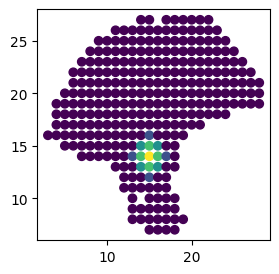

In [4]:
# visualize range of interaction
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))

plt.scatter(adata.obsm['spatial'][:,0], adata.obsm['spatial'][:,1], 
            c=adata.obsp['weight'].A[50])
plt.show()

Next step is to extract valid LR pairs from the database (by default, we use CellChatDB). Filtering out sparsely expressed ligand or receptor (e.g. 3) can help us get more interpretable results later.

In [5]:
# find overlapping LRs from CellChatDB
sdm.extract_lr(adata, 'human', min_cell=3)

## Step 1.1: Global selection of spatially co-expressed LR pairs (z-score approach)

It is a crucial step to identify dataset-specific interacting LR pairs (global selection) for ensuring quality analysis and reliable interpretation of the putative CCC. With high computation efficiency, SpatialDM can complete global selection in seconds. 

In [6]:
import time
start = time.time()

# global Moran selection
sdm.spatialdm_global(adata, method='z-score', nproc=1)

# select significant pairs
sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)

print("%.3f seconds" %(time.time()-start))

10.445 seconds


We used fdr corrected global p-values and a threshold FDR < 0.1 (default) to determine which pairs to be included in the following local identification steps. There are 103 pairs being selected in this data.

In [7]:
print(adata.uns['global_res'].selected.sum())
adata.uns['global_res'].sort_values(by='fdr').head()

172


,Ligand0,Ligand1,Ligand2,Receptor0,Receptor1,Receptor2,z_pval,z,fdr,selected
CCL21_CCR7,CCL21,None,None,CCR7,None,None,2.351186e-63,16.761051,2.118419e-60,True
CD99_CD99,CD99,None,None,CD99,None,None,1.786933e-60,16.361968,8.050133e-58,True
PECAM1_PECAM1,PECAM1,None,None,PECAM1,None,None,6.034266e-50,14.813025,1.812291e-47,True
ESAM_ESAM,ESAM,None,None,ESAM,None,None,6.911664e-48,14.490942,1.556852e-45,True
SPP1_ITGAV_ITGB5,SPP1,None,None,ITGAV,ITGB5,None,2.987723e-46,14.229915,5.383876e-44,True


## Step 1.2: Local selection of interacting spots (z-score approach)

Local selection is then carried out for the selected 103 pairs to identify where the LRI take place, in a single-spot resolution.

In [8]:
start = time.time()
# local spot selection
sdm.spatialdm_local(adata, method='z-score', nproc=1)

# significant local spots
sdm.sig_spots(adata, method='z-score', fdr=False, threshold=0.1)

print("%.3f seconds" %(time.time()-start))

1.582 seconds


By default, local selection is performed for all selected pairs in the previous step. 

<div class="alert alert-info">

**Note**    
Apply an array of integer indices of selected pairs to `select_num` to run local selection in selected pairs
</div>

The global and local results are easily accessible through ```global_res``` and ```local_perm_p``` or ```local_z_p```

## Step 1.3 (exploratory): Visualize pair(s)

SpatialDM provides plotting utilities for general summary of global results:

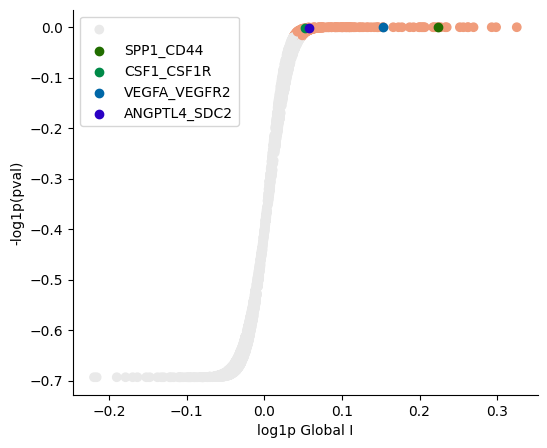

In [9]:
pl.global_plot(adata, pairs=['SPP1_CD44', 'CSF1_CSF1R', 'VEGFA_VEGFR2', 'ANGPTL4_SDC2'], 
               figsize=(6,5), cmap='RdGy_r', vmin=-1.5, vmax=2)

Known melanoma-related pairs were all observed in the selected pairs. It would then be meaningful to investigate the spatial context of their interactions.

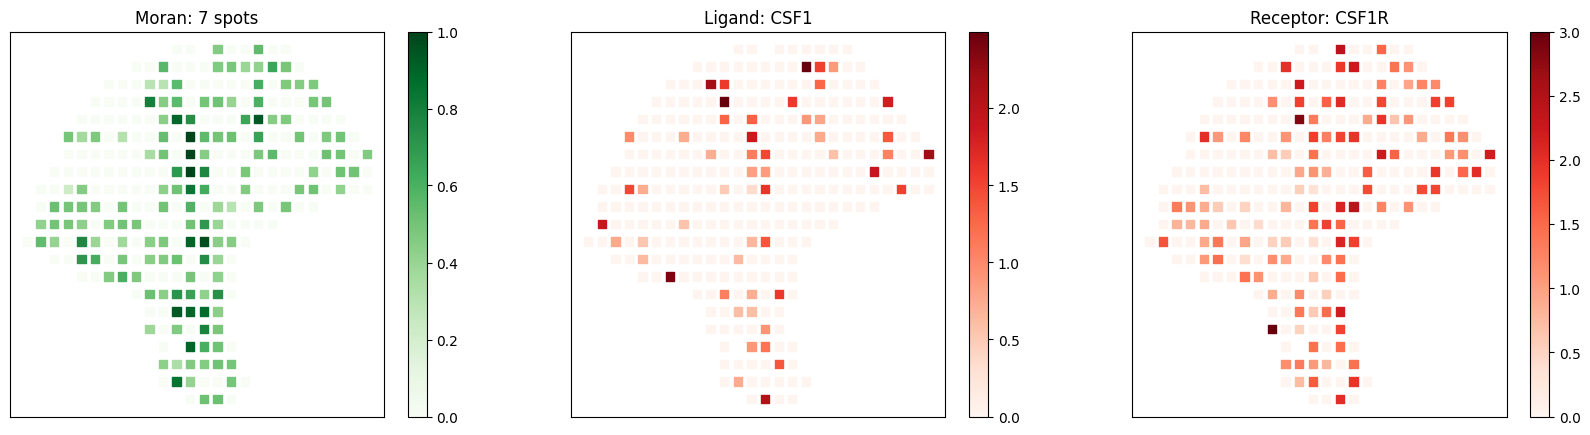

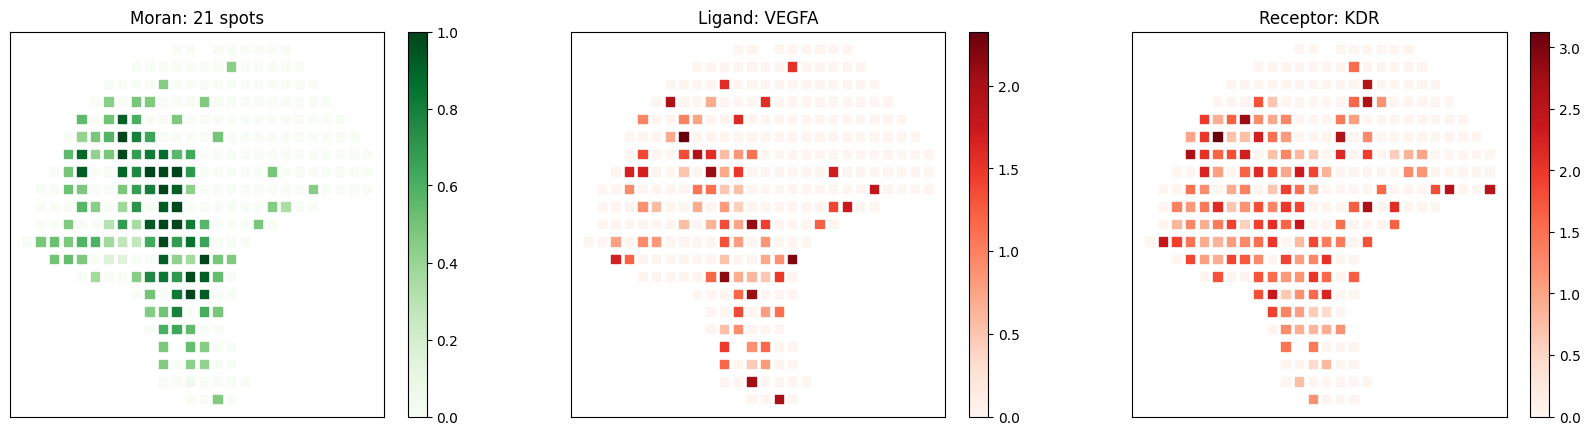

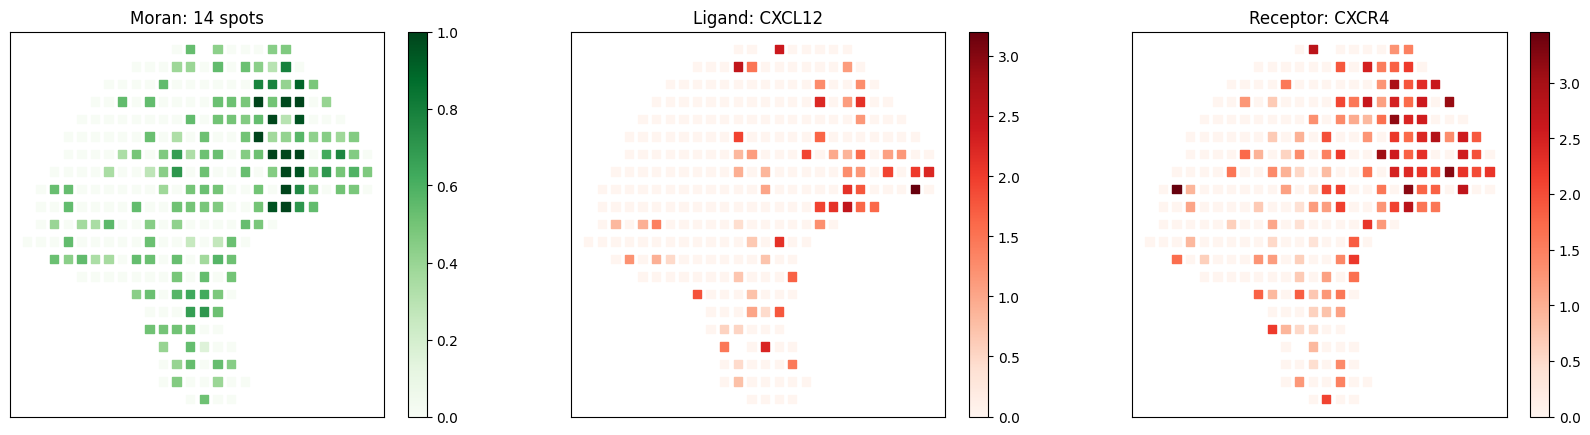

In [10]:
# visualize known melanoma pairs
pl.plot_pairs(adata, ['CSF1_CSF1R', 'VEGFA_VEGFR2', 'CXCL12_CXCR4'], marker='s')

## Step 2: Spatial Clustering of Local Spots

[SparseAEH](https://github.com/jackywangtj66/SparseAEH) allows clustering of spatially auto-correlated genes. Here, we repurposed SpatialDE to identify spatially auto-correlated interactions by using binary local selection status as input.

In [11]:
from SparseAEH import MixedGaussian
from SparseAEH.plot import plot_clusters

Filter out sparse interactions with fewer than 3 identified interacting spots.
Cluster into 6 patterns.

In [12]:
lr_idx = adata.uns['local_stat']['n_spots'] > 2
bin_spots = adata.uns['selected_spots'].astype(int)[lr_idx]
Y = bin_spots.to_numpy()

print(bin_spots.shape[0], "pairs used for spatial clustering")

170 pairs used for spatial clustering


In [13]:
gaussian = MixedGaussian(adata.obsm['spatial'], group_size=16, d=30, l=1e-5)
cluster = gaussian.run_cluster(Y.T, 3, iter=50, init_mean='k_means')

Iteration 0
updating variance
Iteration 1


In [14]:
def plot_clusters(gaussian, label='counts', figsize=(18,16), s=15):
    k = gaussian.K
    h = np.ceil(np.sqrt(k)).astype(int)
    w = np.ceil(k/h).astype(int)
    for i in range(gaussian.K):
        plt.subplot(h, w, i + 1)
        plt.scatter(gaussian.kernel.spatial[:, 0], 
                    gaussian.kernel.spatial[:, 1],
                    marker = 's', c=gaussian.mean[:, i],
                    cmap="viridis", s=s)
        plt.axis('equal')
        # plt.gca().invert_yaxis()
        if label == 'counts':
            plt.title('Pattern %d: %d LR pairs' 
                      %(i, np.sum(gaussian.labels == i)))
        else:
            plt.title('{}'.format(gaussian.pi[i]))
        plt.gcf().set_dpi(300)

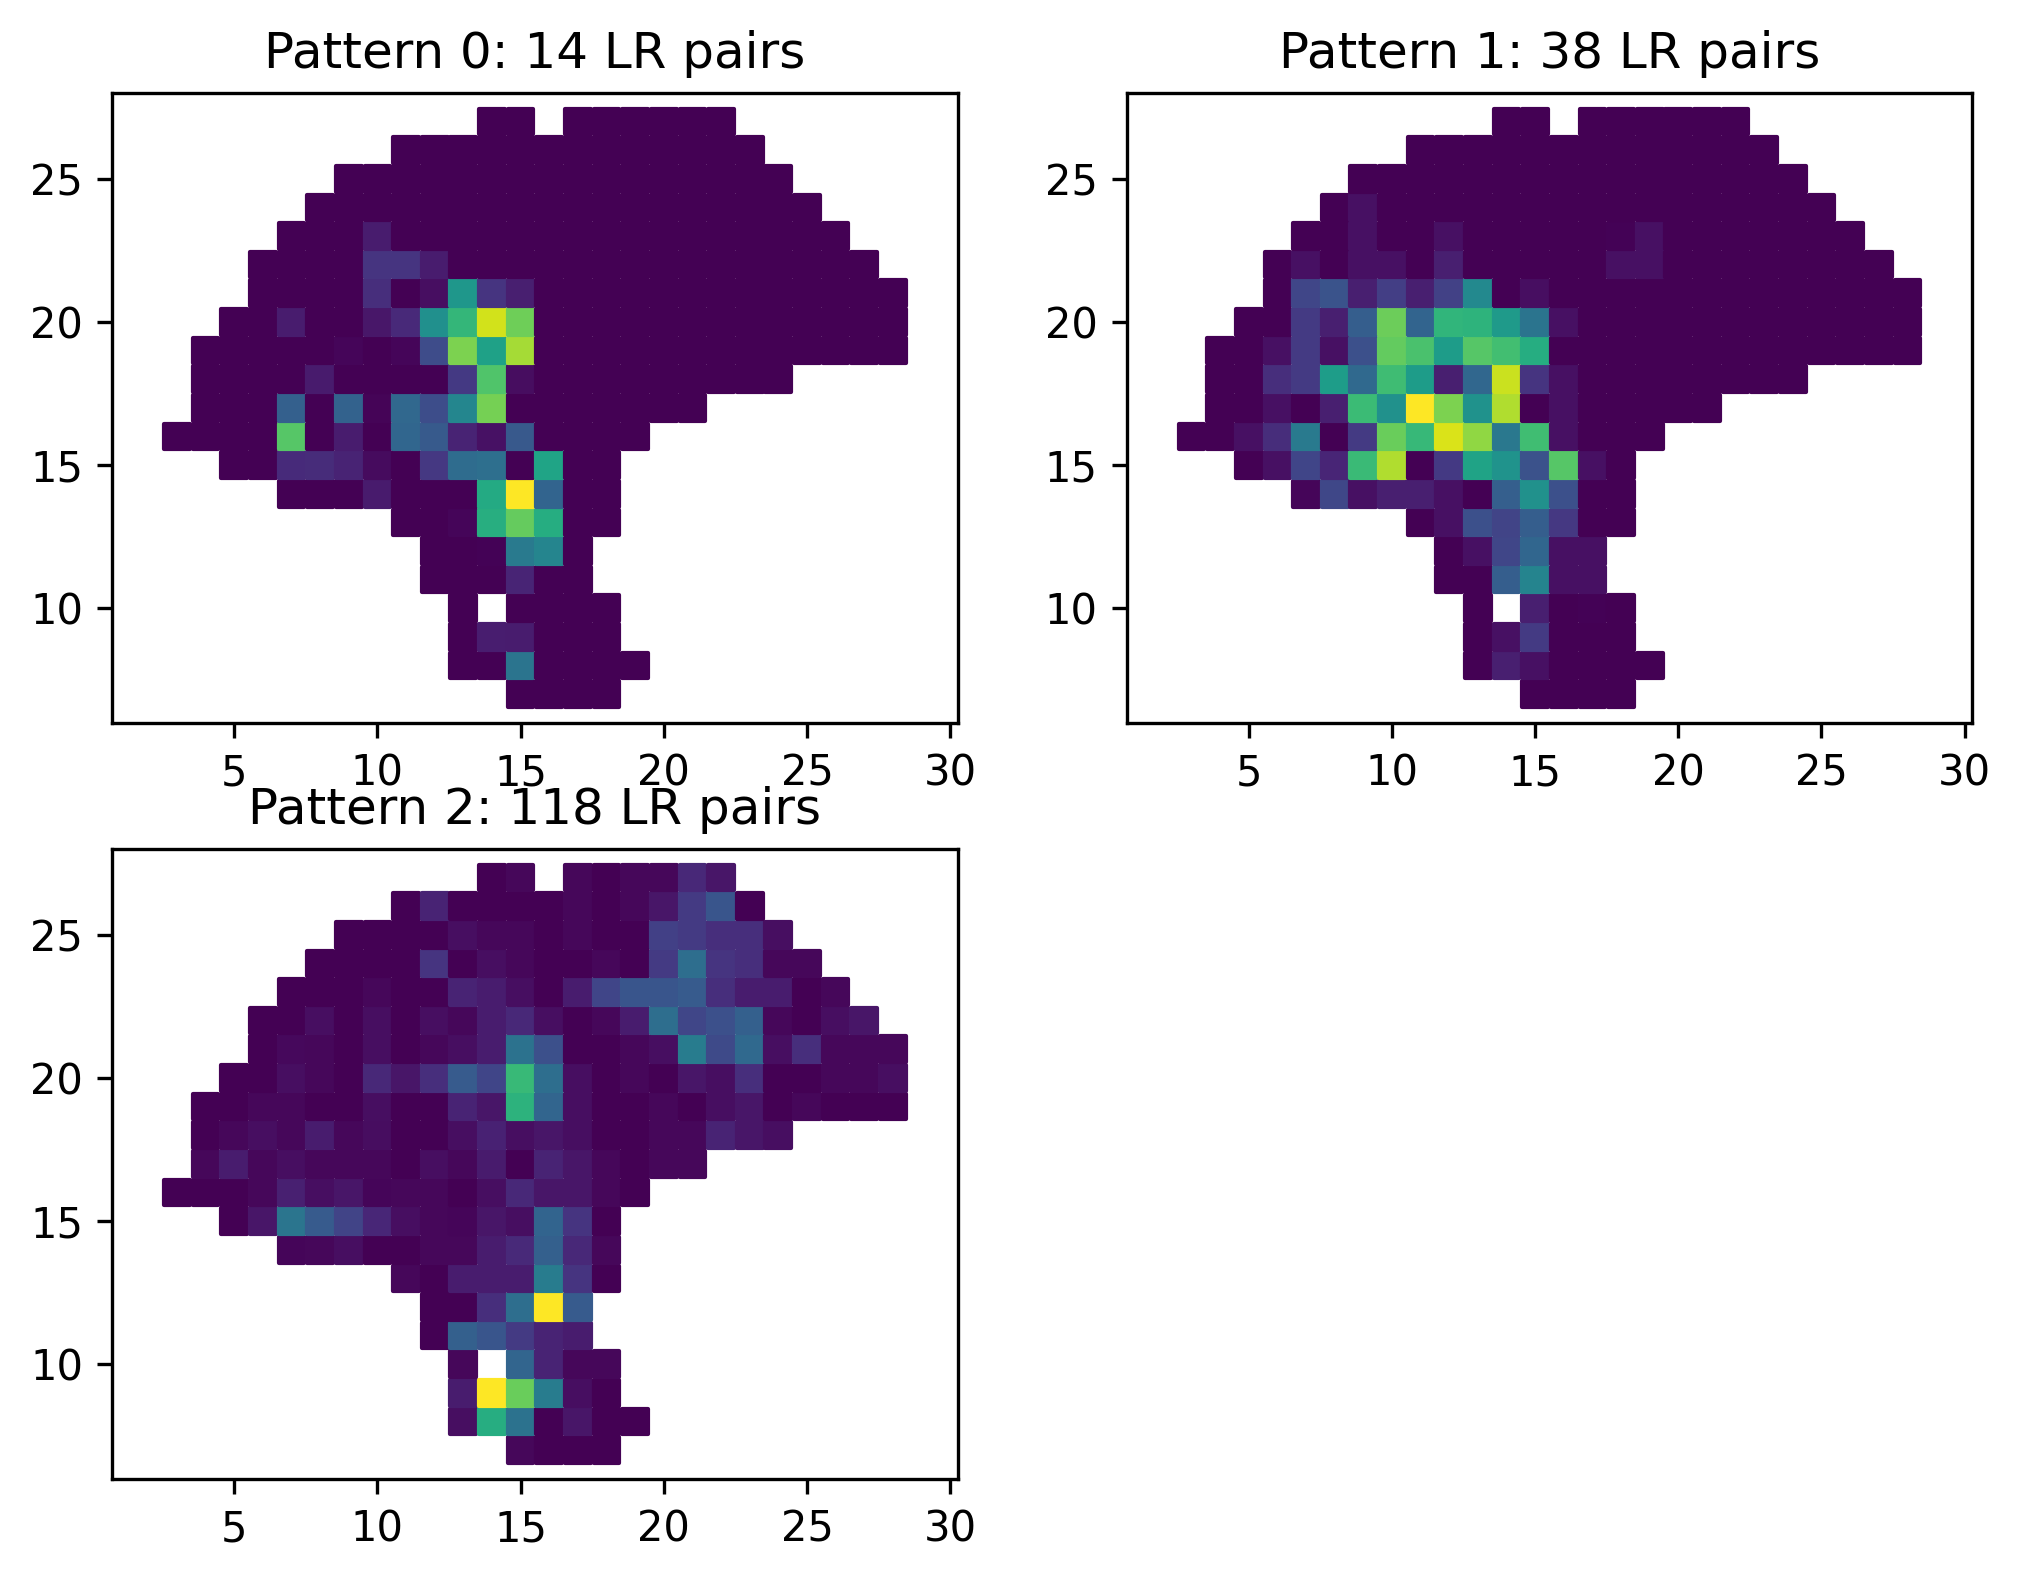

In [15]:
plt.figure(figsize = (8, 6))
plot_clusters(gaussian, s=38)
plt.show()

## Step 3: Pathway enrichment of spatial clusters of LR pairs

SpatialDM provides `compute_pathway` function to group a list of interactions based on the pathways they belong. The input can be a dictionary of several lists.

In [16]:
dic=dict()
for i in range(gaussian.K):
    dic['Pattern_{}'.format(i)]=bin_spots.index[gaussian.labels==i]

Save the anndata file to retrieve later

In [17]:
adata_out = adata.copy()
adata_out.uns['local_stat']['local_permI'] = 'None'
adata_out.uns['local_stat']['local_permI_R'] = 'None'

# sdm.write_spatialdm_h5ad(adata_out, filename='mel_sdm_out.h5ad')
# sdm.read_spatialdm_h5ad(filename='mel_sdm_out.h5ad')

Conduct pathway enrichment analysis

In [18]:
pathway_res = sdm.compute_pathway(adata,dic=dic)
pathway_res

,total_genes,query_genes,overlapped_genes,background_mapped_genes,background_unmapped_genes,selected,fisher_p,pattern
pathway,,,,,,,,
ACTIVIN,INHBA_ACVR1B_ACVR2A INHBA_ACVR1B_ACVR2A...,"{VEGFA_VEGFR2, SPP1_ITGAV_ITGB3, POSTN_ITGAV_I...",{},{},"{SEMA3C_NRP1_PLXNA1, FN1_ITGAV_ITGB1, COL4A2_I...",0,1.000000,Pattern_0
ADIPONECTIN,ADIPOQ_ADIPOR1 ADIPOQ_ADIPOR1 ADIPOQ_ADIPOR...,"{VEGFA_VEGFR2, SPP1_ITGAV_ITGB3, POSTN_ITGAV_I...",{},{},"{SEMA3C_NRP1_PLXNA1, FN1_ITGAV_ITGB1, COL4A2_I...",0,1.000000,Pattern_0
AGRN,"AGRN_DAG1 AGRN_DAG1 Name: interaction_name,...","{VEGFA_VEGFR2, SPP1_ITGAV_ITGB3, POSTN_ITGAV_I...",{},{},"{SEMA3C_NRP1_PLXNA1, FN1_ITGAV_ITGB1, COL4A2_I...",0,1.000000,Pattern_0
ALCAM,"ALCAM_CD6 ALCAM_CD6 Name: interaction_name,...","{VEGFA_VEGFR2, SPP1_ITGAV_ITGB3, POSTN_ITGAV_I...",{},{},"{SEMA3C_NRP1_PLXNA1, FN1_ITGAV_ITGB1, COL4A2_I...",0,1.000000,Pattern_0
AMH,AMH_AMHR2_BMPR1A AMH_AMHR2_BMPR1A AMH_AMHR2...,"{VEGFA_VEGFR2, SPP1_ITGAV_ITGB3, POSTN_ITGAV_I...",{},{},"{SEMA3C_NRP1_PLXNA1, FN1_ITGAV_ITGB1, COL4A2_I...",0,1.000000,Pattern_0
...,...,...,...,...,...,...,...,...
VISFATIN,NAMPT_INSR NAMPT_INSR NAMPT_I...,"{FN1_ITGAV_ITGB1, COL4A2_ITGA1_ITGB1, THBS2_CD...",{},{},"{SEMA3C_NRP1_PLXNA1, FN1_SDC4, VEGFA_VEGFR2, G...",0,1.000000,Pattern_2
VWF,VWF_ITGAV_ITGB3 VWF_ITGAV_I...,"{FN1_ITGAV_ITGB1, COL4A2_ITGA1_ITGB1, THBS2_CD...",{VWF_GP1BA_GP1BB_GP5_GP9},{},"{SEMA3C_NRP1_PLXNA1, FN1_SDC4, VEGFA_VEGFR2, G...",1,0.344017,Pattern_2
WNT,WNT10A_FZD9_LRP6 WNT10A_FZD9_LRP6 WNT10A_...,"{FN1_ITGAV_ITGB1, COL4A2_ITGA1_ITGB1, THBS2_CD...",{},{},"{SEMA3C_NRP1_PLXNA1, FN1_SDC4, VEGFA_VEGFR2, G...",0,1.000000,Pattern_2


In the dot plot of the lymphoid-associated pattern, we identified CD23 and other immune-related pathways.

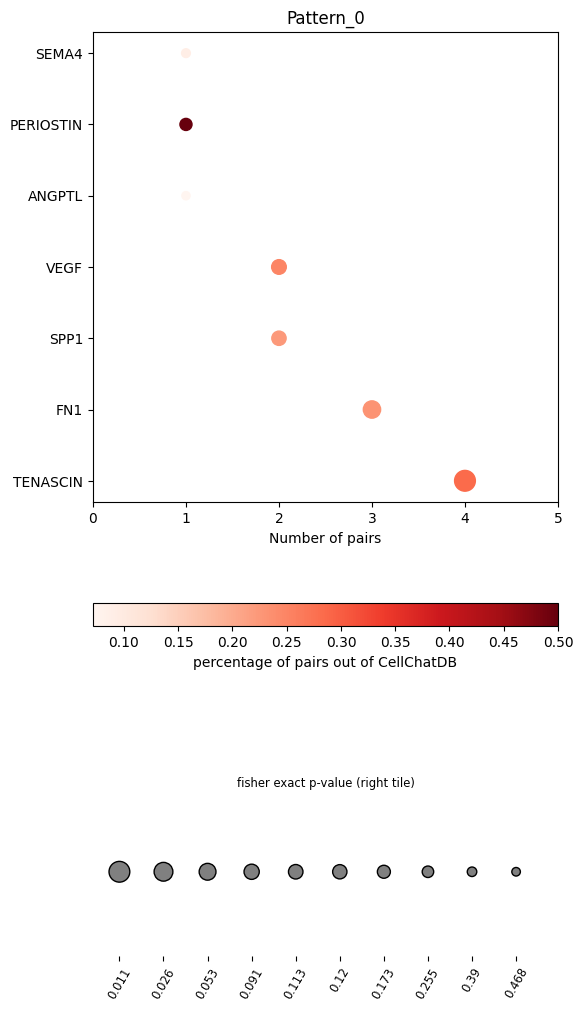

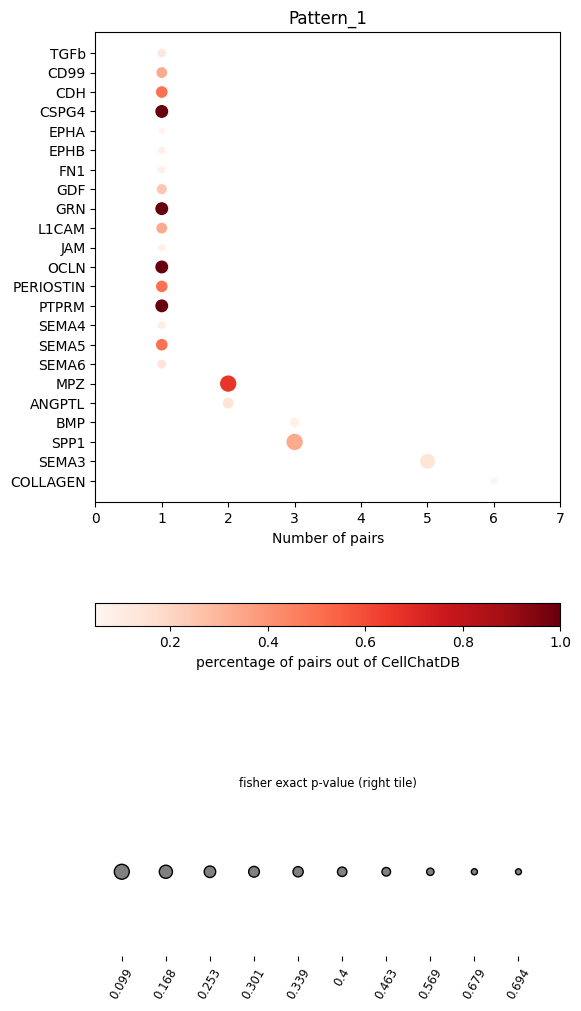

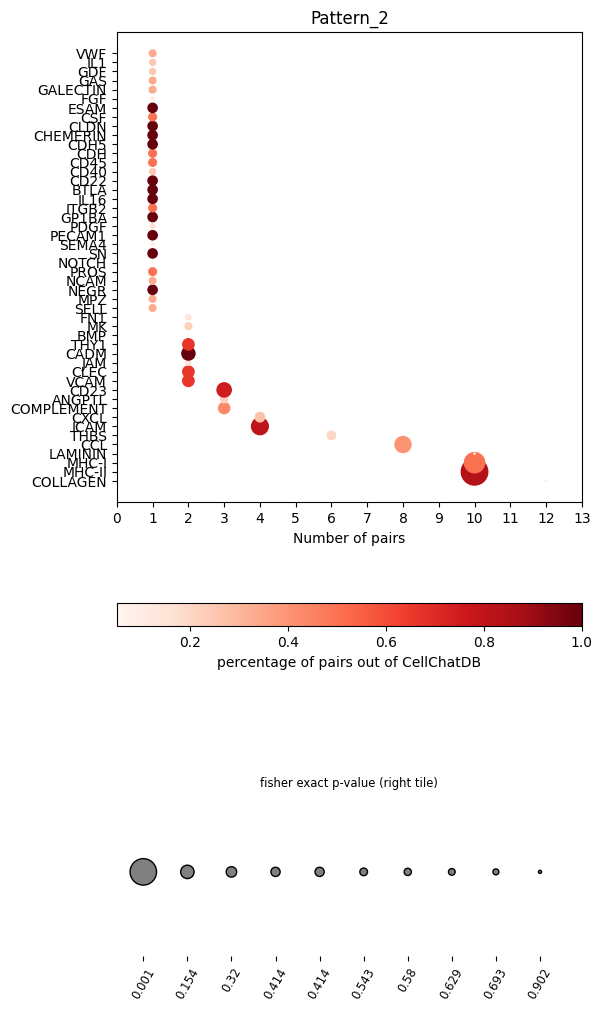

In [19]:
pl.dot_path(pathway_res, figsize=(6,12))

Misc:

SpatialDM provides `chord_celltype` and other chord diagrams to visualize the aggregated cell types (or interactions).

Change the next block from text to code to make the chord plot: